<span style="font-size:18px; font-weight:bold">Stochastic simulation and analysis of the predator-prey dynamic using Gillespie model in Vivarium</span>


Simulation ID: StochasticPredatorPrey
Created: 09/26/2024 at 11:12:20
Completed in 0.023853 seconds


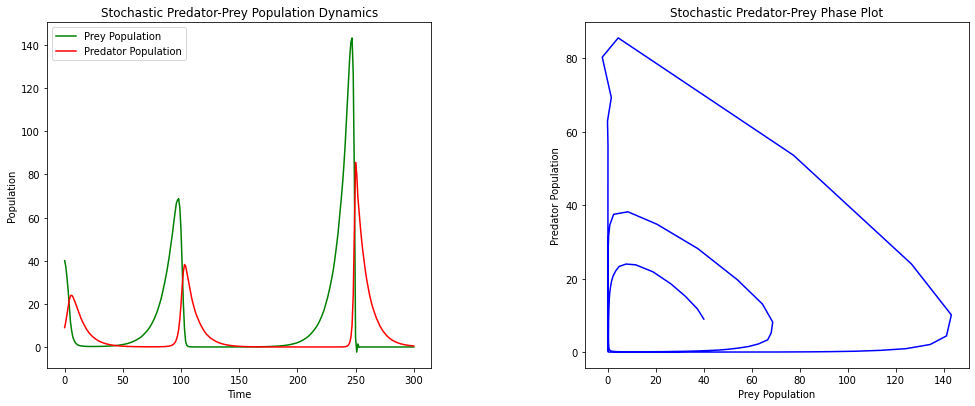

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from vivarium.core.process import Process
from vivarium.core.engine import Engine

# Stochastic Predator-Prey process
class StochasticPredatorPrey(Process):
    
    defaults = {
        'alpha': 0.1,  # Prey growth rate
        'beta': 0.02,  # Predation rate
        'gamma': 0.1,  # Predator death rate
        'delta': 0.01,  # Predator growth rate due to predation
        'noise_scale': 0.05  # Scaling factor for stochastic noise
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

    def ports_schema(self):
        return {
            'prey': {
                'x': {
                    '_default': 40.0,
                    '_emit': True,
                    '_updater': 'accumulate'
                }
            },
            'predator': {
                'y': {
                    '_default': 9.0,
                    '_emit': True,
                    '_updater': 'accumulate'
                }
            }
        }

    def next_update(self, timestep, states):
        x = states['prey']['x']  # Current prey population
        y = states['predator']['y']  # Current predator population

        # Adding stochastic noise to growth and predation rates
        alpha_noise = self.parameters['alpha'] * (1 + np.random.normal(0, self.parameters['noise_scale']))
        beta_noise = self.parameters['beta'] * (1 + np.random.normal(0, self.parameters['noise_scale']))
        gamma_noise = self.parameters['gamma'] * (1 + np.random.normal(0, self.parameters['noise_scale']))
        delta_noise = self.parameters['delta'] * (1 + np.random.normal(0, self.parameters['noise_scale']))

        # Stochastic Predator-Prey model dynamics
        dx = (alpha_noise * x - beta_noise * x * y) * timestep
        dy = (delta_noise * x * y - gamma_noise * y) * timestep

        # Return the updates for prey and predator populations
        return {
            'prey': {'x': dx},
            'predator': {'y': dy}
        }

# Helper function for experiment setup
def process_in_experiment(process, settings, initial_state):
    composite = process.generate()
    return Engine(
        composite=composite,
        initial_state=initial_state,
        **settings)

# Simulation configuration
stochastic_predator_prey_config = {'time_step': 1}
stochastic_predator_prey_sim_settings = {'experiment_id': 'StochasticPredatorPrey'}
stochastic_predator_prey_initial_state = {
    'prey': {'x': 40.0},
    'predator': {'y': 9.0}
}

# Initialize the stochastic predator-prey process
stochastic_predator_prey_process = StochasticPredatorPrey(stochastic_predator_prey_config)

# Create the experiment
stochastic_predator_prey_exp = process_in_experiment(
    stochastic_predator_prey_process,
    stochastic_predator_prey_sim_settings,
    stochastic_predator_prey_initial_state
)

# Run the simulation for 300 timesteps
stochastic_predator_prey_exp.update(300)

# Retrieve the timeseries data from the simulation
stochastic_predator_prey_output = stochastic_predator_prey_exp.emitter.get_timeseries()

# Plotting the results (Phase curve and time series)

# Extract prey and predator data
prey_population = stochastic_predator_prey_output['prey']['x']
predator_population = stochastic_predator_prey_output['predator']['y']

# Create a 2-column and 1-row subplot layout, adjusting width and space
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 2], 'wspace': 0.4})

# First plot: Time series (Prey and Predator population over time)
axes[0].plot(prey_population, label='Prey Population', color='green')
axes[0].plot(predator_population, label='Predator Population', color='red')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_title('Stochastic Predator-Prey Population Dynamics')
axes[0].legend()
axes[0].grid(False)

# Second plot: Phase plot (Prey vs Predator)
axes[1].plot(prey_population, predator_population, color='blue')
axes[1].set_xlabel('Prey Population')
axes[1].set_ylabel('Predator Population')
axes[1].set_title('Stochastic Predator-Prey Phase Plot')
axes[1].grid(False)

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4)

# Save the combined figure
# plt.savefig('stochastic_predator_prey_combined_plot.png', dpi=300)

# Show the combined figure
plt.show()


<span style="font-size:18px; font-weight:bold">Gillespie model simulation of the predator-prey dynamic in Vivarium</span>


Simulation ID: StochasticPredatorPrey
Created: 09/26/2024 at 11:54:36
Completed in 0.016714 seconds


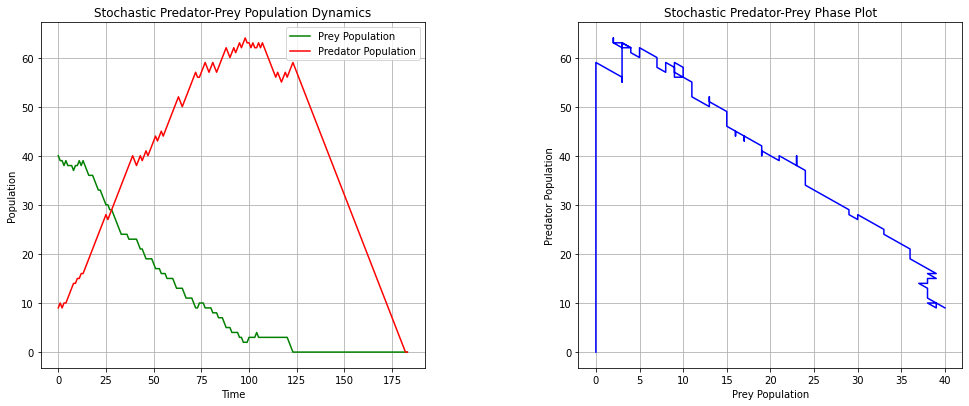

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from vivarium.core.process import Process
from vivarium.core.engine import Engine
from vivarium.library.units import units

class StochasticPredatorPrey(Process):
    defaults = {
        'alpha': 0.1,  # Prey growth rate
        'beta': 0.02,  # Predation rate
        'gamma': 0.1,  # Predator death rate
        'delta': 0.01,  # Predator growth rate due to predation
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.stoichiometry = np.array([[1, 0], [-1, 1], [0, -1], [0, 1]])  # Reactions

    def initial_state(self, config=None):
        return {
            'prey': {'x': 40.0},  # Prey population
            'predator': {'y': 9.0}  # Predator population
        }

    def ports_schema(self):
        return {
            'prey': {
                'x': {
                    '_default': 40.0,
                    '_emit': True,
                    '_updater': 'accumulate',
                }
            },
            'predator': {
                'y': {
                    '_default': 9.0,
                    '_emit': True,
                    '_updater': 'accumulate',
                }
            }
        }

    def calculate_timestep(self, states):
        x = states['prey']['x']
        y = states['predator']['y']
        # Calculate propensities for the Gillespie algorithm
        propensities = [
            self.parameters['alpha'] * x,  # Prey birth rate
            self.parameters['beta'] * x * y,  # Predation rate
            self.parameters['gamma'] * y,  # Predator death rate
            self.parameters['delta'] * x * y  # Predator birth rate
        ]
        prop_sum = sum(propensities)
        
        if prop_sum > 0:
            return np.random.exponential(1 / prop_sum)
        else:
            return float('inf') 
    

    def next_reaction(self, x, y):
        propensities = [
            self.parameters['alpha'] * x,
            self.parameters['beta'] * x * y,
            self.parameters['gamma'] * y,
            self.parameters['delta'] * x * y
        ]
        prop_sum = sum(propensities)

        if prop_sum == 0:
            return None  # This should be handled in next_update

        r_rxn = np.random.uniform(0, prop_sum)
        total = 0
        for i, propensity in enumerate(propensities):
            total += propensity
            if r_rxn < total:
                return self.stoichiometry[i]
        return None  # Handle the edge case where no reaction is chosen

    def next_update(self, timestep, states):
        x = states['prey']['x']
        y = states['predator']['y']

        # Calculate the next reaction
        reaction = self.next_reaction(x, y)
        if reaction is None:
            return {'prey': {'x': 0}, 'predator': {'y': 0}}  # No change if no reaction

        # Apply the reaction
        new_x = x + reaction[0]
        new_y = y + reaction[1]

        return {
            'prey': {'x': new_x - x},
            'predator': {'y': new_y - y}
        }

# Helper functions
def process_in_experiment(process, settings, initial_state):
    composite = process.generate()
    return Engine(
        composite=composite,
        initial_state=initial_state,
        **settings)

# Simulation configuration
stochastic_predator_prey_config = {'time_step': 1}
stochastic_predator_prey_sim_settings = {'experiment_id': 'StochasticPredatorPrey'}
stochastic_predator_prey_initial_state = {
    'prey': {'x': 40.0},
    'predator': {'y': 9.0}
}

# Initialize stochastic predator-prey process
stochastic_predator_prey_process = StochasticPredatorPrey(stochastic_predator_prey_config)

# Create experiment
stochastic_predator_prey_exp = process_in_experiment(
    stochastic_predator_prey_process,
    stochastic_predator_prey_sim_settings,
    stochastic_predator_prey_initial_state
)

# Run the simulation for 1000 timesteps
stochastic_predator_prey_exp.update(1000)

# Retrieve the timeseries data from the simulation
stochastic_predator_prey_output = stochastic_predator_prey_exp.emitter.get_timeseries()

# Plotting the results (Phase curve and time series)

# Extract prey and predator data
prey_population = stochastic_predator_prey_output['prey']['x']
predator_population = stochastic_predator_prey_output['predator']['y']

# Create two plots by subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 2], 'wspace': 0.4})

# First plot: Time series (Prey and Predator population over time)
axes[0].plot(prey_population, label='Prey Population', color='green')
axes[0].plot(predator_population, label='Predator Population', color='red')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_title('Stochastic Predator-Prey Population Dynamics')
axes[0].legend()
axes[0].grid(True)

# Second plot: Phase plot (Prey vs Predator)
axes[1].plot(prey_population, predator_population, color='blue')
axes[1].set_xlabel('Prey Population')
axes[1].set_ylabel('Predator Population')
axes[1].set_title('Stochastic Predator-Prey Phase Plot')
axes[1].grid(True)

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4)


# Save the combined figure
plt.savefig('gillespie_predator_prey_combined_plot.png', dpi=300)

# Show the combined figure
plt.show()



Simulation ID: GillespiePredatorPrey
Created: 09/26/2024 at 11:20:32
Completed in 0.065792 seconds


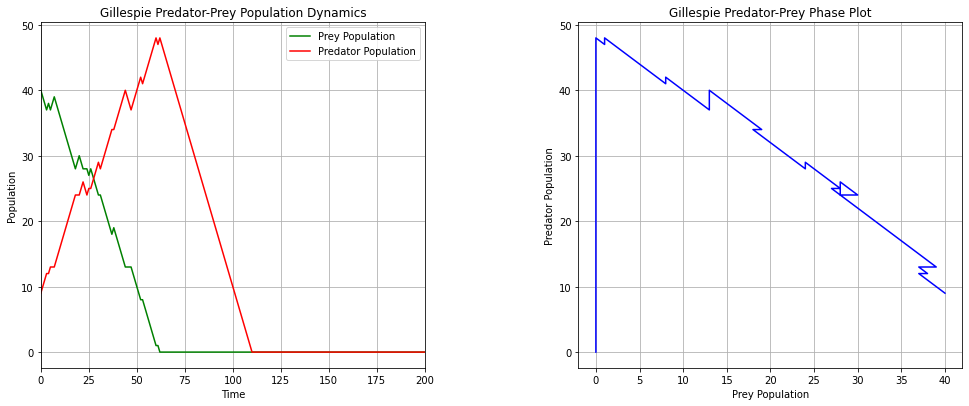

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from vivarium.core.process import Process
from vivarium.core.engine import Engine

# Stochastic Predator-Prey process using the Gillespie Algorithm
class GillespiePredatorPrey(Process):
    
    defaults = {
        'alpha': 0.1,  # Prey birth rate
        'beta': 0.02,  # Predation rate
        'gamma': 0.1,  # Predator death rate
        'delta': 0.01,  # Predator reproduction rate
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

    def ports_schema(self):
        return {
            'prey': {
                'x': {
                    '_default': 40.0,
                    '_emit': True,
                    '_updater': 'accumulate'
                }
            },
            'predator': {
                'y': {
                    '_default': 9.0,
                    '_emit': True,
                    '_updater': 'accumulate'
                }
            }
        }

    def next_update(self, timestep, states):
        x = states['prey']['x']  # Current prey population
        y = states['predator']['y']  # Current predator population
        
        # Propensities for each event based on the current state
        prey_birth_rate = self.parameters['alpha'] * x
        predation_rate = self.parameters['beta'] * x * y
        predator_death_rate = self.parameters['gamma'] * y
        predator_reproduction_rate = self.parameters['delta'] * x * y

        # Total rate of all events
        total_rate = prey_birth_rate + predation_rate + predator_death_rate + predator_reproduction_rate

        if total_rate == 0:
            return {'prey': {'x': 0}, 'predator': {'y': 0}}

        # Time until next event
        tau = np.random.exponential(1.0 / total_rate)

        # Determine which event occurs
        rand = np.random.uniform(0, total_rate)

        if rand < prey_birth_rate:
            # Prey birth event
            dx, dy = 1, 0
        elif rand < prey_birth_rate + predation_rate:
            # Predation event (prey decreases, predator increases)
            dx, dy = -1, 1
        elif rand < prey_birth_rate + predation_rate + predator_death_rate:
            # Predator death event
            dx, dy = 0, -1
        else:
            # Predator reproduction event (prey decreases, predator increases)
            dx, dy = -1, 1

        # Return the updates for prey and predator populations
        return {
            'prey': {'x': dx},
            'predator': {'y': dy},
            '_time': tau  # Update time according to the event occurrence
        }

# Helper function for experiment setup
def process_in_experiment(process, settings, initial_state):
    composite = process.generate()
    return Engine(
        composite=composite,
        initial_state=initial_state,
        **settings)

# Simulation configuration
gillespie_predator_prey_config = {'time_step': 1}
gillespie_predator_prey_sim_settings = {'experiment_id': 'GillespiePredatorPrey'}
gillespie_predator_prey_initial_state = {
    'prey': {'x': 40.0},
    'predator': {'y': 9.0}
}

# Initialize the Gillespie predator-prey process
gillespie_predator_prey_process = GillespiePredatorPrey(gillespie_predator_prey_config)

# Create the experiment
gillespie_predator_prey_exp = process_in_experiment(
    gillespie_predator_prey_process,
    gillespie_predator_prey_sim_settings,
    gillespie_predator_prey_initial_state
)

# Run the simulation for 300 timesteps
gillespie_predator_prey_exp.update(1000)

# Retrieve the timeseries data from the simulation
gillespie_predator_prey_output = gillespie_predator_prey_exp.emitter.get_timeseries()

# Plotting the results

# Extract time, prey, and predator data
times = gillespie_predator_prey_output['time']
prey_population = gillespie_predator_prey_output['prey']['x']
predator_population = gillespie_predator_prey_output['predator']['y']

# Create a 2-column and 1-row subplot layout, adjusting width and space
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 2], 'wspace': 0.4})

# First plot: Time series (Prey and Predator population over time)
axes[0].plot(times, prey_population, label='Prey Population', color='green')
axes[0].plot(times, predator_population, label='Predator Population', color='red')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_title('Gillespie Predator-Prey Population Dynamics')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(0, 200)  # Limiting the x-axis from 0 to 200

# Second plot: Phase plot (Prey vs Predator)
axes[1].plot(prey_population, predator_population, color='blue')
axes[1].set_xlabel('Prey Population')
axes[1].set_ylabel('Predator Population')
axes[1].set_title('Gillespie Predator-Prey Phase Plot')
axes[1].grid(True)

# Adjust the layout
# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4)

# Save the combined figure
# plt.savefig('gillespie_predator_prey_combined_plot.png', dpi=300)

# Show the combined figure
plt.show()
